In [ ]:
%matplotlib inline

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None

url = 'https://s3.amazonaws.com/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv'
training_data = pd.read_csv(url, index_col=0)
training_data.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


### Examining the dataset:

In [32]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

                 FTE         Total
count  126071.000000  3.957220e+05
mean        0.426794  1.310586e+04
std         0.573576  3.682254e+05
min        -0.087551 -8.746631e+07
25%         0.000792  7.379770e+01
50%         0.130927  4.612300e+02
75%         1.000000  3.652662e+03
max        46.800000  1.297000e+08


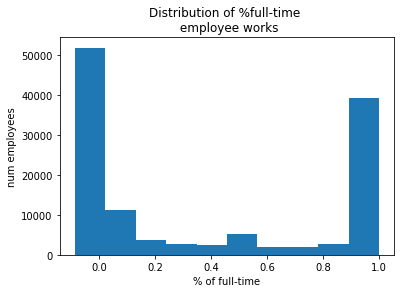

In [33]:
df = training_data

# Print the summary statistics
print(df.describe())

# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(df[df['FTE']<=1].FTE)

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

# Display the histogram
plt.show()

There are 9 labels to be turned into categorical variables.

In [34]:
LABELS = ['Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Use']

# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label)

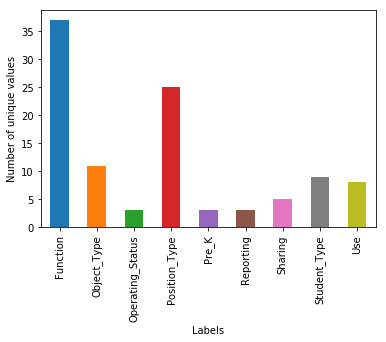

In [35]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

In [36]:
import numpy as np

def compute_log_loss(predicted, actual, eps=1e-14):
    ''' Computes the logarithmic loss between predicted and actual
        when these are 1D arrays
    '''
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1-actual)*np.log(1-predicted))
    
    return loss

### train-test split

Multilabel train-test split.  Code from DrivenData

In [37]:
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [38]:
NUMERIC_COLUMNS = ['FTE', 'Total']

# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
FTE      320222 non-null float64
Total    320222 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 413949
Data columns (total 2 columns):
FTE      80055 non-null float64
Total    80055 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Use_Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 413949
Columns: 104 entries, Function_Aides Compensation to Use_Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 8.6 MB
None


### First model: just numeric columns

In [39]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train,y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.0


This accuracy... isn't great.  But only the numeric columns have been included, so there's a lot of predictive power still unused.

Now let's look at the hold-out dataset:

In [18]:
url = 'https://s3.amazonaws.com/drivendata/data/4/public/d0fcd6d3-5bc5-4869-b4e6-d12ecb2ff517.csv'
holdout_data = pd.read_csv(url, index_col=0)
holdout_data.head()

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1
180042,Student Meals/Room/Other,Basic Educational Services,NaN,NaN,NaN,Line Item that is paid with Campus' money,School,NaN,Instruction,NaN,NaN,3999.910000,NaN,NaN,General Fund,NaN
28872,Extra Duty/Signing Bonus Pay,Undistributed,NaN,CHEERLEADER DIR,NaN,General,School,NaN,Cocurricular & Extra Curricular Activities,NaN,NaN,3447.320213,NaN,NaN,General Fund,NaN
186915,Professional Salaries,Bilingual Education,NaN,T-EL 1ST BIL,NaN,General,School,1.0,Instruction,NaN,NaN,52738.780869,NaN,NaN,General Fund,NaN
412396,Professional Salaries,Bilingual Education,NaN,T-EL 2ND BIL,NaN,General,School,1.0,Instruction,NaN,NaN,69729.263191,NaN,NaN,General Fund,NaN
427740,Salaries for Support Personnel,Undistributed,NaN,CLERK III- SCH,NaN,General,School,1.0,School Leadership,NaN,NaN,29492.834215,NaN,NaN,General Fund,NaN


In [25]:
# Generate predictions: predictions
predictions = clf.predict_proba(holdout_data[NUMERIC_COLUMNS].fillna(-1000))

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [40]:
# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns,
                             index=holdout_data.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv('dc_budget_predictions.csv')
prediction_df.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,Function__Special Population Program Management & Support,Function__Student Assignment,Function__Student Transportation,Function__Substitute Compensation,Function__Teacher Compensation,Function__Untracked Budget Set-Aside,Function__Utilities,Object_Type__Base Salary/Compensation,Object_Type__Benefits,Object_Type__Contracted Services,Object_Type__Equipment & Equipment Lease,Object_Type__NO_LABEL,Object_Type__Other Compensation/Stipend,Object_Type__Other Non-Compensation,Object_Type__Rent/Utilities,Object_Type__Substitute Compensation,Object_Type__Supplies/Materials,Object_Type__Travel & Conferences,Operating_Status__Non-Operating,"Operating_Status__Operating, Not PreK-12",Operating_Status__PreK-12 Operating,Position_Type__(Exec) Director,Position_Type__Area Officers,Position_Type__Club Advisor/Coach,Position_Type__Coordinator/Manager,Position_Type__Custodian,Position_Type__Guidance Counselor,Position_Type__Instructional Coach,Position_Type__Librarian,Position_Type__NO_LABEL,Position_Type__Non-Position,Position_Type__Nurse,Position_Type__Nurse Aide,Position_Type__Occupational Therapist,Position_Type__Other,Position_Type__Physical Therapist,Position_Type__Principal,Position_Type__Psychologist,Position_Type__School Monitor/Security,Position_Type__Sec/Clerk/Other Admin,Position_Type__Social Worker,Position_Type__Speech Therapist,Position_Type__Substitute,Position_Type__TA,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.036441,0.006446,0.000820,0.024319,0.008861,0.000114,0.031728,0.024925,0.051972,0.000063,0.006010,0.035066,0.001540,0.003244,0.071649,0.000190,0.000304,0.012804,0.199736,0.001845,0.006565,0.006190,0.015192,0.056303,0.001786,0.003891,0.030509,0.007985,0.006861,0.011193,0.010905,0.000875,0.031202,0.091845,0.185316,0.001248,0.005938,0.015982,0.073712,0.439571,0.038678,0.254550,0.113968,0.062382,0.001248,0.045863,0.198628,0.575378,0.068649,0.111564,0.189649,0.227515,0.582878,0.000251,0.008345,0.018585,0.004546,0.301933,0.047460,0.015178,0.086560,0.517080,0.000725,0.000129,0.012049,0.018139,0.021012,0.005868,0.014012,0.004888,0.337109,0.065502,0.005047,0.000028,0.001248,0.083972,0.000712,0.005058,0.004428,0.005056,0.019410,0.004121,0.005225,0.091302,0.042302,0.239669,0.004748,0.058710,0.298097,0.026897,0.016103,0.191751,0.191213,0.022558,0.010719,0.037640,0.115582,0.017155,0.830945,0.141202,0.027866,0.169747,0.019915,0.810351
28872,0.036444,0.006446,0.000820,0.024319,0.008861,0.000114,0.031728,0.024926

**SUBMISSION** : loss = 2.7010, worse than uniform submission...

### Natural Language Processing

In [42]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace=True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

There are 385 tokens in Position_Extra if we split on non-alpha numeric
['1st', '2nd', '3rd', '4th', '56', '5th', '9th', 'a', 'ab', 'accountability', 'adaptive', 'addit', 'additional', 'adm', 'admin']


In [43]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [44]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 4757 tokens in the dataset
There are 3284 alpha-numeric tokens in the dataset


### Pipelines (feature and text preprocessing)

In [45]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

In [49]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer

# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train,y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.3549934420086191


Trying a new model: Random Forest.

In [50]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15)) # default is 10
    ])

# Fit to the training data
pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1135547b8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprec...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [51]:
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.9147086378115046


In [53]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

changing the CountVectorizer to use alpha-numeric tokens, reducing dimensions, scaling, and adding an interaction term with the SparseInteractions code above.

In [116]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 300 best features
chi_k = 300

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the winning model pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
#        ('clf', RandomForestClassifier(n_estimators=15))
    ])

# Fit to the training data
#pl.fit(X_train, y_train)
pl.fit(df[NON_LABELS], dummy_labels)

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x113a3ebf8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprec...=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [58]:
NON_LABELS

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [64]:
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)



Accuracy on budget dataset:  0.8549247392417713


In [117]:
#predictions = np.transpose(np.array(pl.predict_proba(holdout_data[NON_LABELS]))[:,:,1])
predictions = pl.predict_proba(holdout_data[NON_LABELS])

prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns,
                             index=holdout_data.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv('dc_budget_predictions4.csv')
prediction_df.head()

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,Function__Special Population Program Management & Support,Function__Student Assignment,Function__Student Transportation,Function__Substitute Compensation,Function__Teacher Compensation,Function__Untracked Budget Set-Aside,Function__Utilities,Object_Type__Base Salary/Compensation,Object_Type__Benefits,Object_Type__Contracted Services,Object_Type__Equipment & Equipment Lease,Object_Type__NO_LABEL,Object_Type__Other Compensation/Stipend,Object_Type__Other Non-Compensation,Object_Type__Rent/Utilities,Object_Type__Substitute Compensation,Object_Type__Supplies/Materials,Object_Type__Travel & Conferences,Operating_Status__Non-Operating,"Operating_Status__Operating, Not PreK-12",Operating_Status__PreK-12 Operating,Position_Type__(Exec) Director,Position_Type__Area Officers,Position_Type__Club Advisor/Coach,Position_Type__Coordinator/Manager,Position_Type__Custodian,Position_Type__Guidance Counselor,Position_Type__Instructional Coach,Position_Type__Librarian,Position_Type__NO_LABEL,Position_Type__Non-Position,Position_Type__Nurse,Position_Type__Nurse Aide,Position_Type__Occupational Therapist,Position_Type__Other,Position_Type__Physical Therapist,Position_Type__Principal,Position_Type__Psychologist,Position_Type__School Monitor/Security,Position_Type__Sec/Clerk/Other Admin,Position_Type__Social Worker,Position_Type__Speech Therapist,Position_Type__Substitute,Position_Type__TA,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.000146,0.000316,0.000038,0.000588,0.005746,0.000244,0.047616,0.000233,0.001857,0.000055,0.000535,0.000123,0.000137,0.000331,0.462049,0.000306,0.000090,0.000873,0.034957,0.000049,0.119793,0.000206,0.000134,0.004182,0.000047,0.000666,0.000736,0.000658,0.000824,0.000200,0.000241,0.000135,0.000473,1.414298e-04,0.003637,0.002046,0.006371,0.000441,4.080330e-03,0.033209,0.004431,0.006594,0.144779,0.022312,9.282754e-03,1.881924e-05,0.826242,0.000366,0.000328,0.032448,0.964018,0.000319,0.000167,0.000382,0.000543,0.000108,0.002468,0.000462,0.000783,0.981994,0.000127,0.000273,0.000013,0.000024,0.004363,0.000017,0.000072,0.000096,0.000055,0.000589,0.000033,0.000064,3.602345e-05,0.001429,0.012442,0.000785,0.998692,0.004975,0.000136,0.035967,0.006453,0.801341,0.005794,0.055977,0.749553,0.000883,0.001739,0.002690,0.000060,0.001161,0.000170,0.023453,0.000470,0.000027,0.000105,0.995218,0.004832,0.017012,0.462826,0.001655,0.034129,0.009521,0.020768,0.002046
28872,0.000108,0.000216,0.000078,0.000025,0.000290,0.0000